In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./cc_fraud_data/fraudTrain.csv')

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Feature Engineering
# Convert columns to correct types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])


In [6]:
# Common function for feature engineering
def extract_date_time_features(df):
    # Extract hour, day of the week, and month from transaction date
    df['transaction_hour'] = df['trans_date_trans_time'].dt.hour
    df['transaction_day'] = df['trans_date_trans_time'].dt.day
    df['transaction_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['transaction_month'] = df['trans_date_trans_time'].dt.month

    # Determine if the transaction occurred on a weekend
    df['is_weekend'] = df['transaction_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Age of the cardholder
    current_year = datetime.now().year
    df['age'] = current_year - df['dob'].dt.year

    # Time since the transaction in seconds
    df['seconds_since_transaction'] = (datetime.now() - df['trans_date_trans_time']).dt.total_seconds()

    return df

def calculate_distance_features(df):
    # Calculate the Haversine distance between the transaction location and the merchant location
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Radius of the Earth in kilometers
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    df['distance_to_merchant'] = df.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1
    )

    return df

def encode_categorical_variables(df):
    # Encode 'category', 'gender', and 'state' using Label Encoding
    label_encoders = {}
    for col in ['category', 'gender', 'state']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # For 'merchant', use frequency encoding (number of transactions per merchant)
    merchant_freq = df['merchant'].value_counts(normalize=True)
    df['merchant_freq'] = df['merchant'].map(merchant_freq)

    # Drop original merchant column if necessary
    df.drop(['merchant'], axis=1, inplace=True)
    return df

def calculate_transaction_amount_features(df):
    # Transaction amount binning (low, medium, high)
    df['amt_category'] = pd.cut(df['amt'], bins=[0, 50, 200, np.inf], labels=['low', 'medium', 'high'])

    # Log transformation of transaction amount
    df['log_amt'] = np.log1p(df['amt'])
    return df

def calculate_additional_features(df):
    # Ratio of transaction amount to city population
    df['amt_city_pop_ratio'] = df['amt'] / df['city_pop']

    # Calculate frequency of transactions per card number (could be based on historical data if available)
    card_freq = df['cc_num'].value_counts()
    df['card_transaction_frequency'] = df['cc_num'].map(card_freq)

    # Transaction hour category (morning, afternoon, evening, night)
    def time_of_day(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'

    df['transaction_time_of_day'] = df['transaction_hour'].apply(time_of_day)

    # Drop unnecessary columns if needed
    df.drop(['trans_date_trans_time', 'dob', 'cc_num', 'street', 'city', 'zip', 'job', 'trans_num'], axis=1, inplace=True)

    # Calculate 'transaction_per_hour'
    df['transaction_per_hour'] = df.groupby('transaction_hour')['unix_time'].transform('size')

    # Calculate 'average_transaction_amount' based on 'amt'
    df['average_transaction_amount'] = df.groupby('category')['amt'].transform('mean')

    # Calculate 'average_age' based on 'age'
    df['average_age'] = df.groupby('category')['age'].transform('mean')

    # Calculate 'average_distance' based on 'distance'
    df['average_distance'] = df.groupby('category')['distance_to_merchant'].transform('mean')

    # Calculate 'average_city_pop' based on 'city_pop'
    df['average_city_pop'] = df.groupby('category')['city_pop'].transform('mean')

    # Calculate 'transaction_per_category' based on 'category'
    df['transaction_per_category'] = df.groupby('category')['unix_time'].transform('size')

    # Calculate 'average_is_peak_hour' based on 'is_peak_hour'
    #df['average_is_peak_hour'] = df.groupby('category')['is_peak_hour'].transform('mean')

    # Calculate 'average_is_weekend' based on 'is_weekend'
    df['average_is_weekend'] = df.groupby('category')['is_weekend'].transform('mean')

    # Calculate 'peak_hour' based on transaction hour
    df['peak_hour'] = df['transaction_hour'].apply(lambda x: 'peak' if 7 <= x <= 9 or 16 <= x <= 18 else 'non_peak')

    # Calculate 'is_weekend' based on transaction day of the week
    df['is_weekend'] = df['transaction_day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

    # Calculate 'transaction_per_merchant' based on 'merchant_freq'
    df['transaction_per_merchant'] = df.groupby('merchant_freq')['unix_time'].transform('size')

    # Calculate 'average_transaction_per_merchant' based on 'transaction_per_merchant'
    df['average_transaction_per_merchant'] = df.groupby('category')['transaction_per_merchant'].transform('mean')

    # Calculate 'average_distance_per_merchant' based on 'distance_to_merchant'
    df['average_distance_per_merchant'] = df.groupby('category')['distance_to_merchant'].transform('mean')
    return df

In [7]:
df_1 = extract_date_time_features(df)

In [112]:
df_2 = calculate_distance_features(df_1)

In [113]:
df_3 = encode_categorical_variables(df_2)

In [114]:
df_4 = calculate_transaction_amount_features(df_3)

In [115]:
df_5 = calculate_additional_features(df_4)

In [69]:
#df = calculate_additional_features(df)

In [116]:
df_5.columns

Index(['Unnamed: 0', 'category', 'amt', 'first', 'last', 'gender', 'state',
       'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'transaction_hour', 'transaction_day',
       'transaction_day_of_week', 'transaction_month', 'is_weekend', 'age',
       'seconds_since_transaction', 'distance_to_merchant', 'merchant_freq',
       'amt_category', 'log_amt', 'amt_city_pop_ratio',
       'card_transaction_frequency', 'transaction_time_of_day',
       'transaction_per_hour', 'average_transaction_amount', 'average_age',
       'average_distance', 'average_city_pop', 'transaction_per_category',
       'average_is_weekend', 'peak_hour', 'transaction_per_merchant',
       'average_transaction_per_merchant', 'average_distance_per_merchant'],
      dtype='object')

## EDA

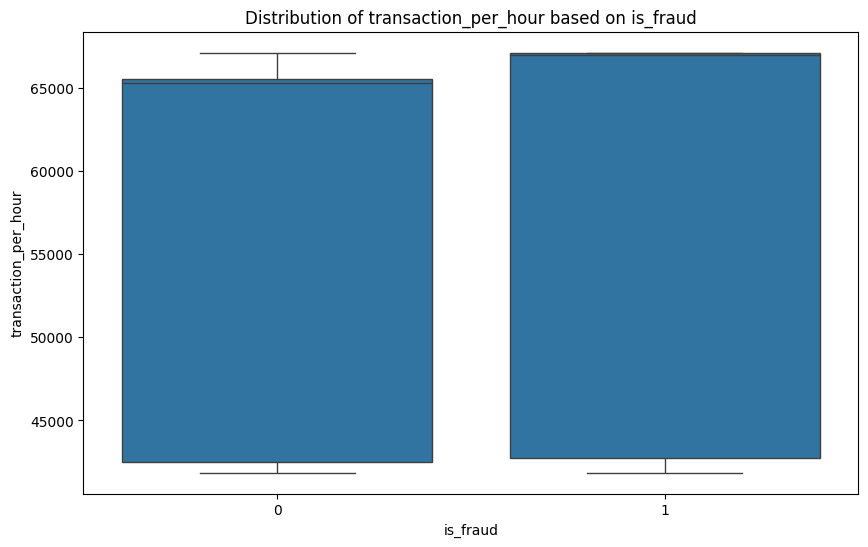

In [122]:
# Exploratory Data Analysis (EDA) with 'is_fraud'
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of 'transaction_per_hour' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='transaction_per_hour', data=df)
plt.title('Distribution of transaction_per_hour based on is_fraud')
plt.show()

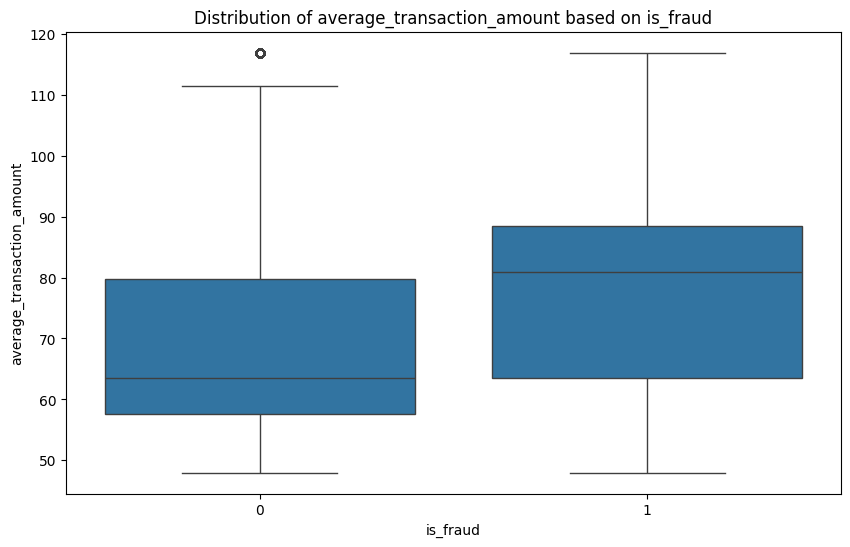

In [124]:
# Distribution of 'average_transaction_amount' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_transaction_amount', data=df)
plt.title('Distribution of average_transaction_amount based on is_fraud')
plt.show()

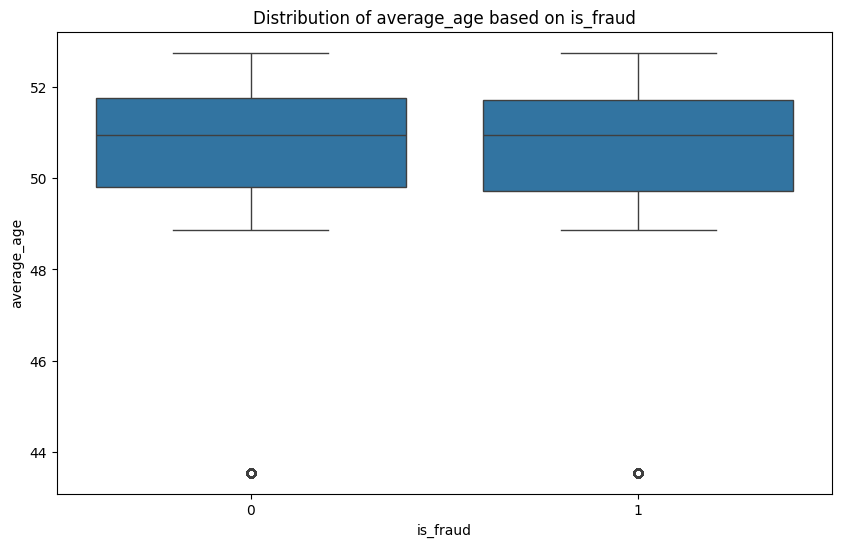

In [125]:
# Distribution of 'average_age' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_age', data=df)
plt.title('Distribution of average_age based on is_fraud')
plt.show()

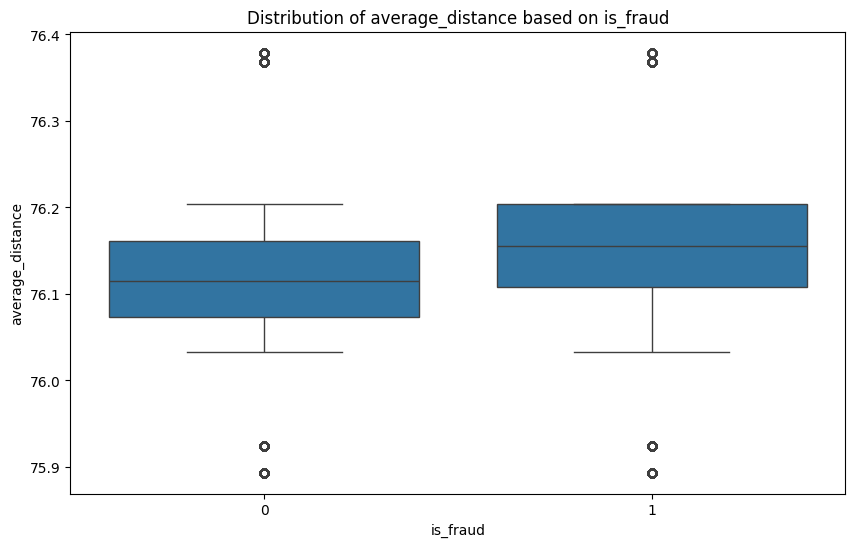

In [126]:
# Distribution of 'average_distance' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_distance', data=df)
plt.title('Distribution of average_distance based on is_fraud')
plt.show()

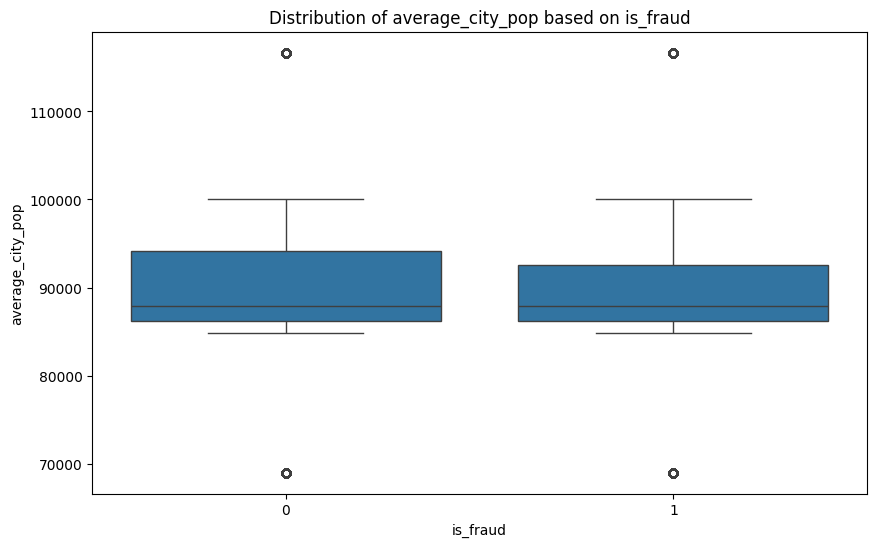

In [127]:
# Distribution of 'average_city_pop' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_city_pop', data=df)
plt.title('Distribution of average_city_pop based on is_fraud')
plt.show()

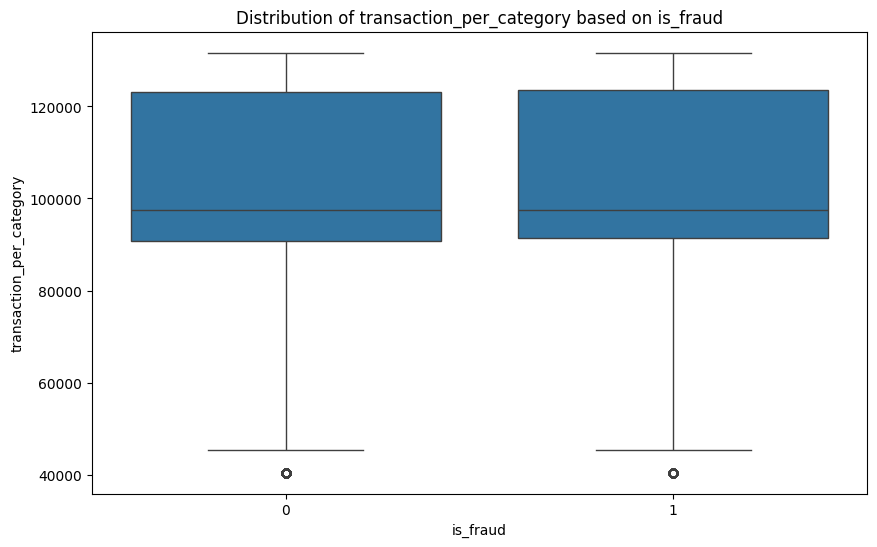

In [128]:
# Distribution of 'transaction_per_category' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='transaction_per_category', data=df)
plt.title('Distribution of transaction_per_category based on is_fraud')
plt.show()

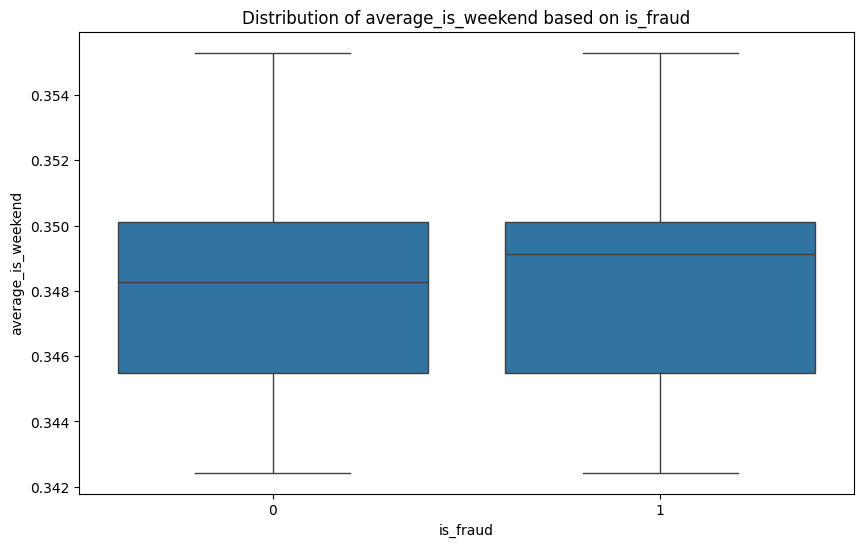

In [130]:
# Distribution of 'average_is_weekend' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_is_weekend', data=df)
plt.title('Distribution of average_is_weekend based on is_fraud')
plt.show()

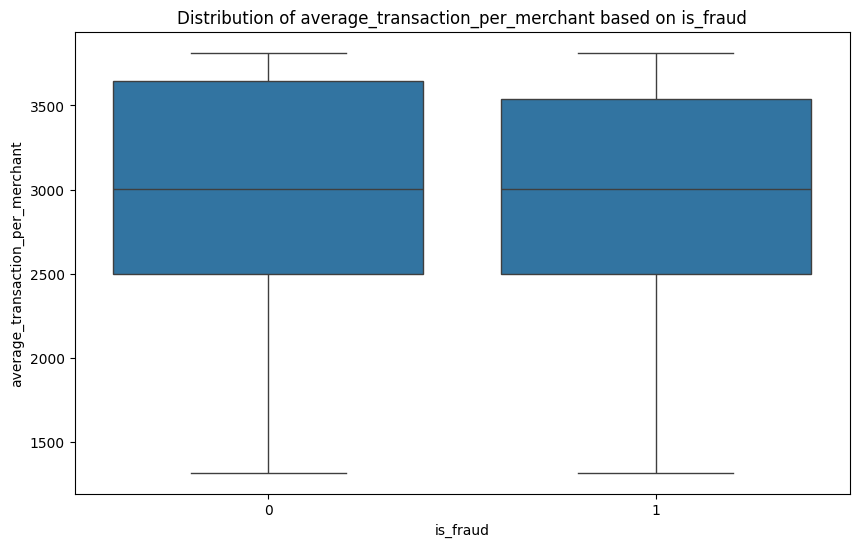

In [131]:
# Distribution of 'average_transaction_per_merchant' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_transaction_per_merchant', data=df)
plt.title('Distribution of average_transaction_per_merchant based on is_fraud')
plt.show()


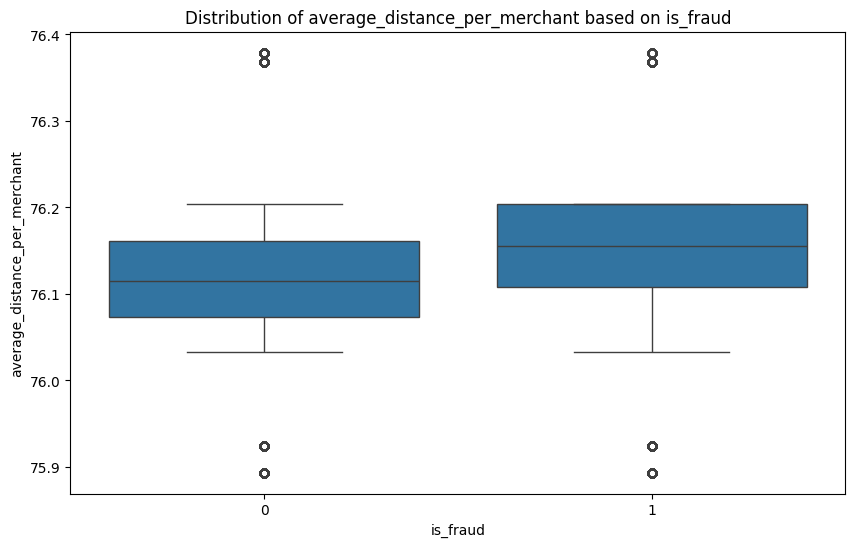

In [132]:
# Distribution of 'average_distance_per_merchant' based on 'is_fraud'
plt.figure(figsize=(10,6))
sns.boxplot(x='is_fraud', y='average_distance_per_merchant', data=df)
plt.title('Distribution of average_distance_per_merchant based on is_fraud')
plt.show()